In [1]:
from matplotlib import pyplot as plt
from typing import Tuple, NamedTuple, Generator
%matplotlib inline

import torch

feat_dim = torch.Size([100, 100])
img_size = (800, 800, 3)
a_bboxes = torch.tensor([
    [452.7114, 323.7556, 454.4020, 408.2842,  41.0000],
    [452.7114, 573.9602, 454.4020, 692.3002,  41.0000],
    [401.9912, 185.1288, 403.6819, 259.5139,  41.0000],
    [478.0714, 185.1288, 479.7621, 259.5139,  41.0000],
    [117.9587, 577.3413, 119.6494, 692.3002,  41.0000],
    [298.8604, 185.1288, 300.5510, 254.4423,  41.0000],
    [117.9587, 372.7822, 119.6494, 435.3334,  41.0000],
    [141.6281, 195.2722, 143.3187, 267.9668,  41.0000],
    [655.5918, 185.1288, 657.2825, 254.4423,  41.0000],
    [658.9730, 274.7291, 660.6637, 360.9482,  41.0000]
])
o_bboxes = torch.tensor([
    [553.0000, 528.5000, 313.0000, 527.2500, 312.9183, 542.9268, 552.9183, 544.1768, 122.0000],
    [239.7677, 707.2427, 183.3551, 703.3521, 182.8018, 711.3743, 239.2145, 715.2649, 121.0000],
    [314.4858, 282.6746, 295.9953, 277.3914, 285.8066, 313.0518, 304.2971, 318.3350,  87.0000],
    [574.2500, 514.7500, 565.5000, 497.2500, 539.0000, 510.5000, 547.7500, 528.0000,  28.0000],
    [125.0001, 515.0000, 116.5001, 498.0000,  92.0000, 510.2500, 100.5000, 527.2500,  24.0000],
    [126.0000, 668.2500, 117.5001, 651.2500,  93.5000, 663.2500, 102.0000, 680.2500,  24.0000],
    [267.7501, 658.0000, 259.2500, 641.0000, 234.2500, 653.5000, 242.7501, 670.5000,  26.0000],
    [374.2500, 319.7500, 365.7500, 302.7500, 340.7500, 315.2500, 349.2500, 332.2500,  24.0000],
    [268.0000, 524.7500, 259.5000, 507.7500, 234.0001, 520.5000, 242.5001, 537.5000,  26.0000],
    [629.7500, 278.2500, 621.2500, 261.2500, 596.7500, 273.5000, 605.2500, 290.5000,  24.0000]
])


In [2]:
def expand_corners(a_bbox: torch.Tensor) -> torch.Tensor:
    # corners = get_coords(a_bbox, 2)
    x0, y0, x2, y2, lbl = a_bbox
    x1, x3 = (x0, x2) if x0 < x2 else (x2, x0)
    y1, y3 = (y2, y0) if y0 < y2 else (y2, y0)
    # print(f"{x0:.6}, {y0:.6} -> {x3:.6}, {y3:.6} ({lbl})")
    # print(f"{x0:.6}/{y0:.6}   ---   {x1:.6}/{y1:.6}")
    # print("       |                       |")
    # print("       |                       |")
    # print("       |                       |")
    # print(f"{x3:.6}/{y3:.6}   ---   {x2:.6}/{y2:.6}")
    return torch.stack((x0, y0, x1, y1, x2, y2, x3, y3, lbl))

o_bbox = expand_corners(a_bboxes[0])
o_bbox = o_bboxes[0]
print(o_bbox)

tensor([553.0000, 528.5000, 313.0000, 527.2500, 312.9183, 542.9268, 552.9183,
        544.1768, 122.0000])


In [3]:
def to_points(bbox: torch.Tensor) -> torch.Tensor:
    if len(bbox.size()) != 1:
        raise Exception("Cannot create points from a multi-dimensional tensor.")
    if bbox.size()[0] % 2 != 0:
        raise Exception("Cannot create points from an uneven number of scalars.")
    n_pairs = bbox.size()[0] // 2
    return bbox.view((n_pairs, 2))

def extract(bbox: torch.Tensor) -> Tuple[torch.Tensor, float]:
    return to_points(bbox[:-1]), bbox[-1]

def reassemble_bbox(coords: torch.Tensor, label: float) -> torch.Tensor:
    return torch.cat([torch.flatten(coords), torch.tensor([label])])

points, lbl = extract(o_bbox)
print(points)
print(lbl)

tensor([[553.0000, 528.5000],
        [313.0000, 527.2500],
        [312.9183, 542.9268],
        [552.9183, 544.1768]])
tensor(122.)


In [4]:
def get_convex_hull(corners: torch.Tensor) -> torch.Tensor:
    p0 = torch.min(corners, dim=0).values
    p1 = torch.max(corners, dim=0).values
    return torch.stack((p0, p1))

conv_hull = get_convex_hull(points)
print(conv_hull)

tensor([[312.9183, 527.2500],
        [553.0000, 544.1768]])


In [5]:
def get_conv_hull_center(conv_hull: torch.Tensor) -> torch.Tensor:
    return torch.mean(conv_hull, dim=0)

center = get_conv_hull_center(conv_hull)
print(center)

tensor([432.9592, 535.7134])


In [6]:
import math

def get_angle(coord: torch.Tensor) -> torch.Tensor:
    x, y = coord
    angle = torch.atan(y/x)
    if x < 0:  # quadrant II or III
        angle += math.pi
    elif x > 0 and y < 0:  # quadrant IV
        angle += 2*math.pi
    return angle

def order_corners(points: torch.Tensor) -> torch.Tensor:
    offsets = points - torch.mean(points, dim=0)
    angles = []
    for offset in offsets:
        angle = get_angle(offset)
        angles.append(angle)
        print(f"-- {offset} -> {angle}")
    print(angles)
    print(offsets)
    #TODO: Decide on a good way to order corners

_ = order_corners(points)


-- tensor([120.0408,  -7.2134]) -> 6.223166465759277
-- tensor([-119.9592,   -8.4634]) -> 3.2120282649993896
-- tensor([-120.0409,    7.2134]) -> 3.081573486328125
-- tensor([119.9591,   8.4634]) -> 0.07043599337339401
[tensor(6.2232), tensor(3.2120), tensor(3.0816), tensor(0.0704)]
tensor([[ 120.0408,   -7.2134],
        [-119.9592,   -8.4634],
        [-120.0409,    7.2134],
        [ 119.9591,    8.4634]])


In [7]:
def scale_to_grid_bounds(bboxes: torch.Tensor, feat_dim: torch.Size, img_size: Tuple[int, int, int], type_dict: dict) -> torch.Tensor:
    n_bboxes = bboxes.shape[0]
    # Now cast each bbox to each cell in the energy layer that it covers
    # First bounds of grid squares that have a bbox in them
    x_scale_factor = feat_dim[1] / img_size[1]
    y_scale_factor = feat_dim[0] / img_size[0]
    scale_factor = torch.tensor((x_scale_factor, y_scale_factor,
                                 x_scale_factor, y_scale_factor,
                                 x_scale_factor, y_scale_factor,
                                 x_scale_factor, y_scale_factor,
                                 1.), **type_dict)
    scale_factor = scale_factor.repeat(n_bboxes, 1)

    # scale down bounding boxes to feature size, add 1 to x2,y2 to avoid boxes with size zero
    adder = torch.tensor((
        0, 0,  # x0, y0
        0, 1,  # x1, y1
        1, 0,  # x2, y2
        1, 1,  # x3, y3
        0      # lbl
    ), device=type_dict['device'])
    adder = adder.repeat(n_bboxes, 1)
    return torch.floor(bboxes.to(dtype=torch.float64) * scale_factor).long() + adder

type_dict = {'dtype': a_bboxes.dtype, 'device': a_bboxes.device}
grid_bounds = scale_to_grid_bounds(o_bboxes, feat_dim, img_size, type_dict)
print(grid_bounds)


tensor([[ 69,  66,  39,  66,  40,  67,  70,  69, 122],
        [ 29,  88,  22,  88,  23,  88,  30,  90, 121],
        [ 39,  35,  36,  35,  36,  39,  39,  40,  87],
        [ 71,  64,  70,  63,  68,  63,  69,  67,  28],
        [ 15,  64,  14,  63,  12,  63,  13,  66,  24],
        [ 15,  83,  14,  82,  12,  82,  13,  86,  24],
        [ 33,  82,  32,  81,  30,  81,  31,  84,  26],
        [ 46,  39,  45,  38,  43,  39,  44,  42,  24],
        [ 33,  65,  32,  64,  30,  65,  31,  68,  26],
        [ 78,  34,  77,  33,  75,  34,  76,  37,  24]])


In [8]:
def create_meshgrid(feat_dim: torch.Size, type_dict: dict) -> Tuple[torch.Tensor, torch.Tensor]:
    x_index = torch.arange(0, feat_dim[1], **type_dict).repeat(feat_dim[0], 1)
    y_index = torch.arange(0, feat_dim[0], **type_dict).repeat(feat_dim[1], 1).transpose(0, 1)
    return x_index, y_index

red
tensor([67.8500, 62.5500], dtype=torch.float64)
tensor([-13.3500,   4.4500], dtype=torch.float64)
green
tensor([54.5000, 66.0000], dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
blue
tensor([47.2500, 74.2500], dtype=torch.float64)
tensor([ 7.2500, -7.2500], dtype=torch.float64)
magenta
tensor([54.4358, 67.9624], dtype=torch.float64)
tensor([ 0.0642, -0.9624], dtype=torch.float64)
None


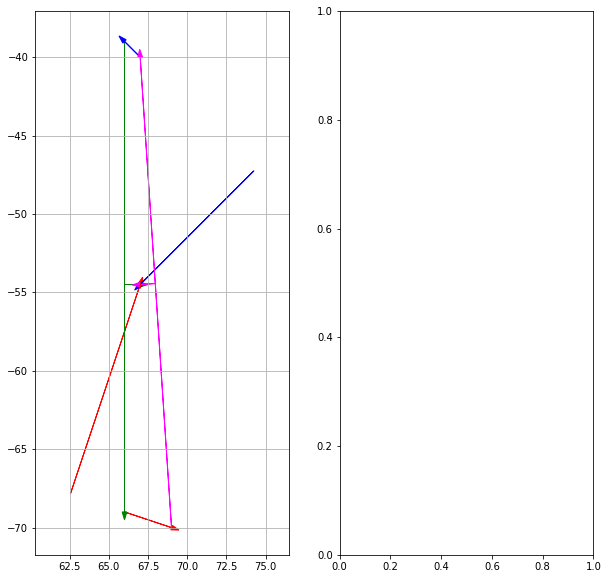

In [9]:
def to_unit_vec(vector: torch.Tensor) -> torch.Tensor:
    """
    Create a unit vector out of an arbitrary vector.

    :param vector: The two-dimensional vector to be made into a unit vector
    """
    vector = vector.to(dtype=torch.float64)
    return vector / torch.sqrt(vector[0]**2 + vector[1]**2)

def gen_edge_vectors(ordered_corners: torch.Tensor) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Generate the edges between corners as vectors.

    :returns: A generator for pairs of corners and adjacent edges leading to the next corner
    """
    flt_corners = ordered_corners.to(dtype=torch.float64)
    n_corners = flt_corners.shape[0]
    for i in range(n_corners):
        vec = flt_corners[(i-1) % n_corners] - flt_corners[i]
        yield ordered_corners[i], vec


def project_ortho(point_B: torch.Tensor, vector: torch.Tensor, point_C: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calculate the orthogonal projection and return the coordinates for A and side b.
    Given points B, C and a line through B defined by a vector, calculate the projection of
    point C onto the line, thereby finding point A with a right angle.

    :param point_B: The coordinates for point B
    :param vector: The vector of side c to project point C onto
    :param point_C: The coordinates for point C
    :returns: A tuple consisting of the coordinates for point A and the vector spanning from point A to C
    """
    orth_proj_skalar = torch.dot(vector, point_C - point_B) / torch.dot(vector, vector)
    point_A = point_B + vector * orth_proj_skalar
    vector_c = point_C - point_A
    return point_A, vector_c

mask_outside=False

def get_mask(energy_layer: torch.Tensor, corners: torch.Tensor) -> torch.Tensor:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10)) #, nrows=1, figsize=(16,10))
    center = torch.mean(corners.to(dtype=torch.float64), dim=0)
    axes[0].plot(center[1], -center[0], 'r+')
    fmts = ['red', 'green', 'blue', 'magenta']
    fmts.reverse()
    for corner, edge in gen_edge_vectors(corners):
        col = fmts.pop()
        print(col)
        axes[0].arrow(
            corner[1], -corner[0],
            edge[1], -edge[0],
            # [corner[1], corner[1] + vec[1]*0.9],
            # [-corner[0], -(corner[0] + vec[0]*0.9)],
            color=col,
            head_width=0.3, head_length=0.5
        )
        axes[0].axis('equal')
        axes[0].set_aspect('equal')
        axes[0].grid(True)
        orth_projection_origin, vector = project_ortho(corner, edge, center)
        print(orth_projection_origin)
        print(vector)
        axes[0].arrow(
            orth_projection_origin[1], -orth_projection_origin[0],
            vector[1], -vector[0],
            color=col,
            head_width=0.3, head_length=0.5
        )

scaled_corners = extract(grid_bounds[0])[0]
print(get_mask(torch.zeros((feat_dim[0], feat_dim[1]), **type_dict), scaled_corners))

In [10]:
bbox_percent = 1
r = 5.0
max_energy = 20

def get_energy_single(feat_dim: torch.Size, img_size: Tuple[int, int, int], bboxes: torch.Tensor)\
            -> NamedTuple("max", (('values', torch.Tensor), ('indices', torch.LongTensor))):
    type_dict = {'dtype': bboxes.dtype, 'device': bboxes.device}
    n_bboxes = bboxes.shape[0]
    if n_bboxes == 0:  # No bboxes to calculate
        return torch.zeros((1, feat_dim[0], feat_dim[1]), **type_dict).max(dim=0)

    energy_layers = [torch.zeros((feat_dim[0], feat_dim[1]), **type_dict) for _ in range(n_bboxes)]
    zero_tensor = torch.tensor(0., **type_dict)

    o_bboxes = torch.zeros((bboxes.size()[0], 9))
    # Make sure every bbox has 4 coordinates
    for i, bbox in enumerate(bboxes):
        points, _ = extract(bbox)
        if points.size()[0] == 2:  # Only two corners given
            bbox = expand_corners(bbox)  # Derive additional two corners
        o_bboxes[i] = bbox

    grid_bounds = scale_to_grid_bounds(o_bboxes, feat_dim, img_size, type_dict)
    print(grid_bounds)

    x_index, y_index = create_meshgrid(feat_dim, type_dict)
    # Fill each energy layer. This is done this way to allow for
    # vectorized calculations.
    for i, gb in enumerate(grid_bounds):
        points, lbl = extract(gb)
        conv_hull = get_convex_hull(points)
        center = get_conv_hull_center(conv_hull)

        # First create the mask of grid areas
        # where the bounding box exists.
        if mask_outside:
            mask = torch.zeros_like(energy_layers[i]).to(dtype=torch.bool)
            mask[gb[1]:gb[3], gb[0]:gb[2]] = True
        else:
            mask = torch.ones_like(energy_layers[i]).to(dtype=torch.bool)


        # x_dist = torch.abs((bbox_dist[0] - (2. * x_index[mask]
        #                                     / x_scale_factor)) / 2)
        #
        # y_dist = torch.abs((bbox_dist[1] - (2. * y_index[mask]
        #                                     / y_scale_factor)) / 2)

        x_dist = torch.abs(center[0] - x_index[mask])
        y_dist = torch.abs(center[1] - y_index[mask])

        if bbox_percent is not None:
            # distances relative to the bbox size
            bbox_size = torch.tensor((gb[2]-gb[0],
                                      gb[3]-gb[1]),
                                     **type_dict)

            x_dist = x_dist / bbox_size[0]
            y_dist = y_dist / bbox_size[1]

        # Multiplied by self is faster than tensor.pow(2) by about 30%
        tot_dist = torch.sqrt((x_dist * x_dist) + (y_dist * y_dist))

        if bbox_percent is not None:
            # energy marker based off bounding box size
            val = 1 - (tot_dist / bbox_percent)

        else:
            # energy marker based off fixed radius
            val = 1 - (tot_dist / r)

        if max_energy != 1:
            val = torch.floor(val * (max_energy-1))

        # torch.max to eliminate negative numbers. torch.max is
        # approximately 20 times faster than using indexing
        val = torch.max(val, zero_tensor)

        energy_layers[i][mask] = val
    energy_layers = torch.cat([torch.unsqueeze(layer, 0) for layer in energy_layers])
    return energy_layers.max(dim=0)

print(get_energy_single(feat_dim, img_size, a_bboxes))
print(get_energy_single(feat_dim, img_size, o_bboxes))

tensor([[56, 40, 56, 52, 57, 51, 57, 41, 41],
        [56, 71, 56, 87, 57, 86, 57, 72, 41],
        [50, 23, 50, 33, 51, 32, 51, 24, 41],
        [59, 23, 59, 33, 60, 32, 60, 24, 41],
        [14, 72, 14, 87, 15, 86, 15, 73, 41],
        [37, 23, 37, 32, 38, 31, 38, 24, 41],
        [14, 46, 14, 55, 15, 54, 15, 47, 41],
        [17, 24, 17, 34, 18, 33, 18, 25, 41],
        [81, 23, 81, 32, 83, 31, 83, 24, 41],
        [82, 34, 82, 46, 83, 45, 83, 35, 41]])


RuntimeError: Can only calculate the mean of floating types. Got Long instead.